In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Apply Rejections

In [2]:
## Load data.
data = read_csv(os.path.join('data','data.csv'))
surveys = read_csv(os.path.join('data','surveys.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)]
surveys = surveys[surveys.subject.isin(reject.query('reject==0').subject)]

## Section 2: Stimulus Random Effects

In [3]:
## Define function to identify block version.
def block_version(df):
    session = df.name[1]; robots = df[:4].value_counts()
    if   (session == 1) and (robots['NGAL'] == 2): return '1a'
    elif (session == 1): return '1b'
    elif (session == 2) and (robots['GAL'] == 2): return '2b'
    elif (session == 2): return '2a'
    elif (session == 3) and (robots['NGW'] == 2): return '3b'
    else: return '3a'
    
## Apply block identification function.
data['version'] = data.groupby(['subject','session','block']).robot.transform(block_version)

#### 2.1 Stimulus effects on average accuracy

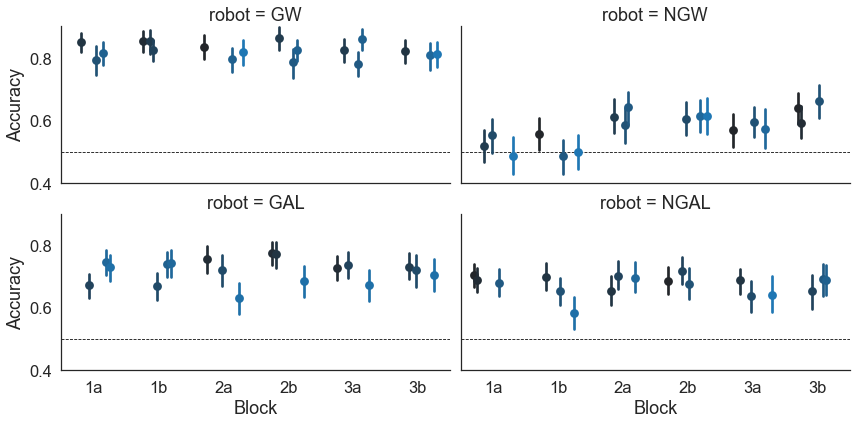

In [4]:
## Compute accuracy by stimulus.
cols = ['version','subject','robot','stimulus']
gb = data.groupby(cols).accuracy.mean().reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='robot', col_order=['GW','NGW','GAL','NGAL'], col_wrap=2, aspect=2)

## Plot accuracy.
g.map(sns.pointplot, 'version', 'accuracy', 'stimulus', order=['1a','1b','2a','2b','3a','3b'], 
      hue_order=np.arange(12), dodge=0.6, join=False)

## Add details.
g.set(ylim=(0.4,0.9))
for ax in g.axes: ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
for ax in g.axes[-2:]: ax.set_xlabel('Block')
for ax in g.axes[::2]: ax.set_ylabel('Accuracy')

#### 2.2 Stimulus effects on first action

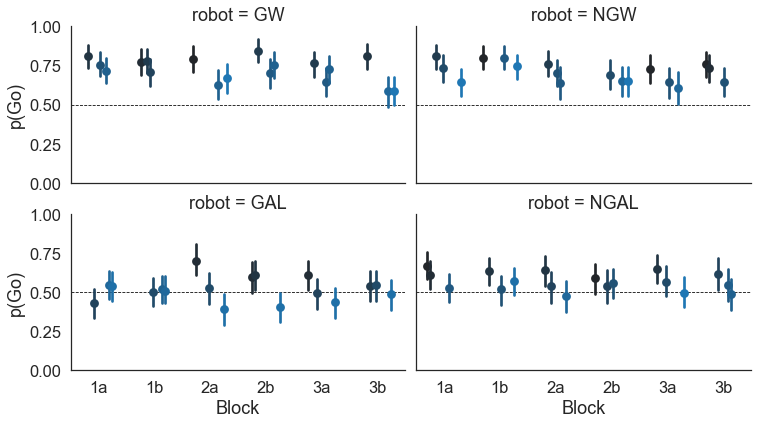

In [5]:
## Compute choice by stimulus.
cols = ['version','subject','robot','stimulus']
gb = data.query('exposure==1').groupby(cols).choice.mean().reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='robot', col_order=['GW','NGW','GAL','NGAL'], col_wrap=2, aspect=1.75)

## Plot accuracy.
g.map(sns.pointplot, 'version', 'choice', 'stimulus', order=['1a','1b','2a','2b','3a','3b'], 
      hue_order=np.arange(12), dodge=0.6, join=False)

## Add details.
g.set(ylim=(0,1))
for ax in g.axes: ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
for ax in g.axes[-2:]: ax.set_xlabel('Block')
for ax in g.axes[::2]: ax.set_ylabel('p(Go)')

#### 2.3 Stimulus effects across learning

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


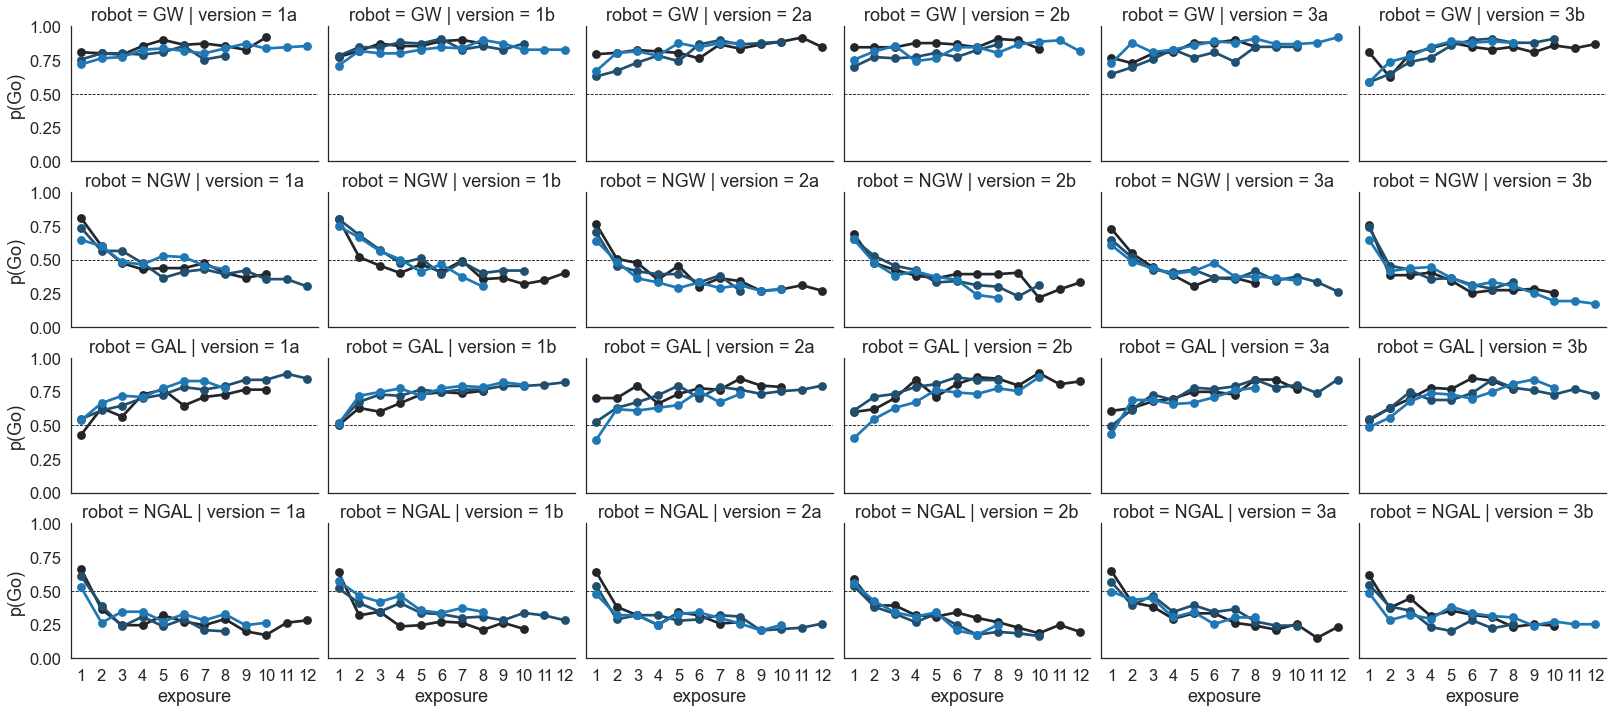

In [6]:
## Initialize canvas.
g = sns.FacetGrid(data, row='robot',  col='version', height=2.5, aspect=1.5,
                  row_order=['GW','NGW','GAL','NGAL'], col_order=['1a','1b','2a','2b','3a','3b'])

## Plot performance.
g.map(sns.pointplot, 'exposure', 'choice', 'stimulus', order=np.arange(12)+1, ci=None)

## Add details.
g.set(ylim=(0,1))
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
for ax in g.axes.flatten()[::6]: ax.set_ylabel('p(Go)')

## Section 3: Outcome Random Effects

#### 3.1 Performance by sham feedback

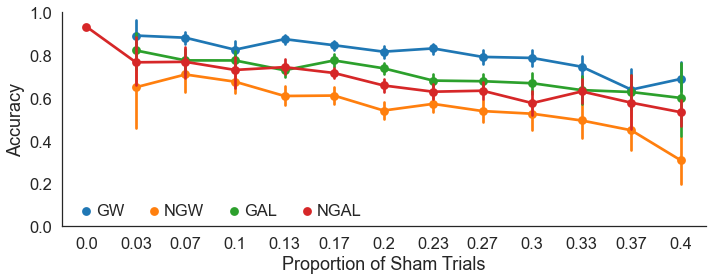

In [7]:
## Compute average performance.
gb = data.groupby(['subject','session','block','robot']).agg({'accuracy':'mean', 'sham':'mean'}).reset_index()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,4))
order = np.linspace(0,0.4,13)

## Plot performance.
sns.pointplot(x='sham', y='accuracy', hue='robot', data=gb, order=order, 
              hue_order=['GW','NGW','GAL','NGAL'], ax=ax)

## Add detail.
ax.set(xticklabels=order.round(2), xlabel='Proportion of Sham Trials', ylim=(0,1), ylabel='Accuracy')
ax.legend(loc=3, frameon=False, ncol=4, handletextpad=-0.4, columnspacing=0.8, borderpad=0)

sns.despine()
plt.tight_layout()

## Section 4: Trial Order Random Effects

#### 4.1 Performance by number of elapsed trials

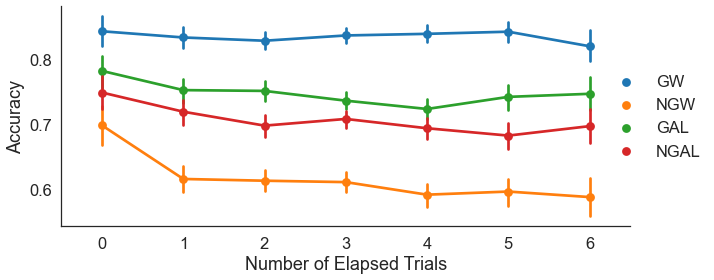

In [8]:
## Re-sort data.
data = data.sort_values(['session','subject','rune'])

## Compute number of trials since last exposure.
data['n_since'] = data.groupby(cols).trial.diff() - 1

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,4))

## Plot accuracy.
sns.pointplot(x='n_since', y='accuracy', hue='robot', data=data, order=np.arange(7), 
              hue_order=['GW','NGW','GAL','NGAL'], ax=ax)

## Add detail.
ax.set(xlabel='Number of Elapsed Trials', ylabel='Accuracy')
ax.legend(loc=7, bbox_to_anchor=(1.15,0.5), frameon=False)

sns.despine()
plt.tight_layout()

## Section 5: Subject Random Effects

#### 5.1 Subject differences in first action

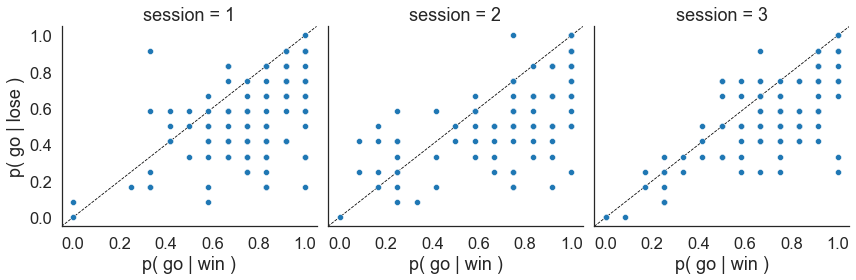

In [9]:
## Compute choice by stimulus.
cols = ['session','subject','valence']
gb = data.query('exposure==1').groupby(cols).choice.mean().reset_index()

## Construct pivot table.
gb = gb.pivot_table('choice',['session','subject'],'valence').reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='session', height=4, aspect=1)

## Plot action.
g.map(sns.scatterplot, 'win', 'lose')

## Add detail.
for ax in g.axes.flatten(): ax.plot([-0.05,1.05], [-0.05,1.05], lw=0.8, linestyle='--', color='k', zorder=-1)
g.set(xlim=[-0.05,1.05], xticks=np.linspace(0,1,6), ylim=[-0.05,1.05], yticks=np.linspace(0,1,6),)
g.set_xlabels('p( go | win )')
g.set_ylabels('p( go | lose )');

#### 5.2 State measures

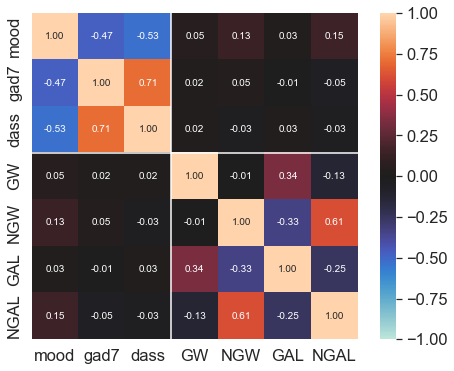

In [10]:
## Compute sum scores within subscales.
surveys['gad7'] = surveys.filter(regex='gad7_q0[1-7]').sum(axis=1)
surveys['dass'] = surveys.filter(regex='dass_q0[1-7]').sum(axis=1)

## Extract columns.
scores = surveys[['subject','session','mood','gad7','dass']]

## Compute average action within participant.
gb = data.groupby(['subject','session','robot']).choice.mean().reset_index()
gb = gb.pivot_table('choice',['subject','session'],'robot').reset_index()

## Merge. Compute correlation matrix.
cols = ['mood','gad7','dass','GW','NGW','GAL','NGAL']
scores = scores.merge(gb, on=['subject','session'])
corr = scores[cols].corr(method='spearman')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot correlations.
sns.heatmap(corr, center=0, vmin=-1, vmax=1, annot=True, fmt='0.2f', square=True, ax=ax)
ax.axhline(3, color='w'); ax.axvline(3, color='w');
ax.set_yticklabels(cols, va='center');

#### 5.3 Personality measures (BIS/BAS)

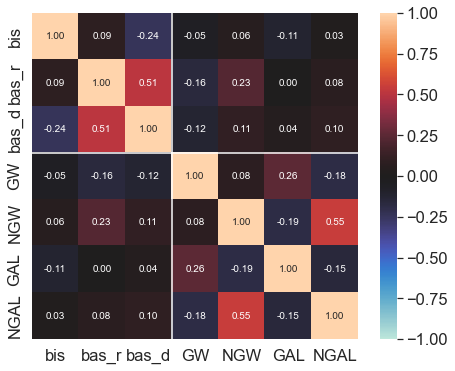

In [11]:
## Compute sum scores within subscales.
surveys['bis']   = surveys[['bisbas_q%0.2d' %i for i in [1,2,3,4]]].sum(axis=1)
surveys['bas_r'] = surveys[['bisbas_q%0.2d' %i for i in [5,6,7,8]]].sum(axis=1)
surveys['bas_d'] = surveys[['bisbas_q%0.2d' %i for i in [9,10,11,12]]].sum(axis=1)

## Extract columns.
scores = surveys.query('session==1')[['subject','bis','bas_r','bas_d']]

## Compute average action within participant.
gb = data.query('session==1').groupby(['subject','robot']).choice.mean().reset_index()
gb = gb.pivot_table('choice','subject','robot')

## Merge. Compute correlation matrix.
cols = ['bis','bas_r','bas_d','GW','NGW','GAL','NGAL']
scores = scores.merge(gb, on='subject')
corr = scores[cols].corr(method='spearman')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot correlations.
sns.heatmap(corr, center=0, vmin=-1, vmax=1, annot=True, fmt='0.2f', square=True, ax=ax)
ax.axhline(3, color='w'); ax.axvline(3, color='w');
ax.set_yticklabels(cols, va='center');